In [1]:
import math
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from torch import optim 
from torchvision.transforms import transforms
from sklearn import datasets
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt 

In [2]:
class Dataset_california(torch.utils.data.Dataset):
    def __init__(self, train = False, test_size=0.25, random_state=13):
        sk_data, sk_target = datasets.fetch_california_housing(return_X_y=True)
        if train:
            self.data, _, self.target, _ = train_test_split(sk_data, sk_target, 
                                                            test_size=test_size, 
                                                            random_state=random_state) 
        else:
            _, self.data, _, self.target = train_test_split(sk_data, sk_target, 
                                                            test_size=test_size, 
                                                            random_state=random_state) 


    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        return self.data[index], self.target[index]

In [3]:
dataset_train = Dataset_california(train=True)
dataset_test = Dataset_california()
len(dataset_train), len(dataset_test)

(15480, 5160)

In [4]:
loader_train = torch.utils.data.DataLoader(dataset_train, batch_size=32, shuffle=True,
                                          num_workers=2, drop_last=True)
loader_test = torch.utils.data.DataLoader(dataset_test, batch_size=32, shuffle=True,
                                          num_workers=2, drop_last=True)
len(loader_train), len(loader_test)

(483, 161)

In [5]:
class Net(nn.Module):
    def __init__(self, hidden_l):
        super().__init__()
        self.net = nn.Sequential(
          nn.BatchNorm1d(8, dtype=torch.float64),
          nn.Linear(8, 8 * hidden_l, dtype=torch.float64),
          nn.LeakyReLU(),
          nn.Linear(8*hidden_l, 4*hidden_l, dtype=torch.float64),
          nn.LeakyReLU(),
          nn.Linear(4*hidden_l, 1, dtype=torch.float64)
          )
        self.mean_target_train = 0
        self.mean_target_test = 0
        self.history = None

    def forward(self, x):
        x = self.net(x)
        return x

    def fit(self, loader_train, loadre_test, epochs, loss, optimazer, lr, show_log=True):
        self.train()
        self.history = []
        self.optimazer = optimazer(self.parameters(), lr)
        self.loss = loss()
        for epoch in range(epochs):
            running_loss = 0.0
            running_items = 0.0
            for i, (X_train, y_train) in enumerate(loader_train):
                self.optimazer.zero_grad()
                outputs = self(X_train)
                loss_iter = self.loss(outputs.reshape(-1), y_train)
                loss_iter.backward()
                self.optimazer.step()
                running_loss += loss_iter.item()
                running_items += len(y_train)
                if i%200 ==0:
                    loss_train = running_loss / running_items
                    loss_test = self.loss_fn(loader_test)
                    self.history.append([epoch+1, i+1, loss_train, loss_test])
                    if show_log:
                        print(f'Epoch [{epoch + 1:2}/{epochs}]. ' \
                              f'Step [{i + 1:3}/{len(loader_train)}]. ' \
                              f'Loss: {loss_train:.4f}  '\
                              f'Loss_test: {loss_test:.4f}'
                              )
                running_loss, running_items = 0.0, 0.0
        print(f'Training is finished with optimazer: {optimazer}')
        return self.history

    def loss_fn(self, loader):
        self.eval()
        running_loss = 0.0
        running_items = 0.0
        for i, (X_data, y_data) in enumerate(loader):
            outputs = self(X_data)
            loss_iter = self.loss(outputs.reshape(-1), y_data)
            running_loss += loss_iter.item()
            running_items += len(y_data)
        self.train()  
        return running_loss / running_items

In [6]:
net = Net(8)
hist = net.fit(loader_train, loader_test, 5, nn.MSELoss, optim.RMSprop, 0.00001, show_log=True)

Epoch [ 1/5]. Step [  1/483]. Loss: 0.2018  Loss_test: 0.0804
Epoch [ 1/5]. Step [201/483]. Loss: 0.1849  Loss_test: 0.1870
Epoch [ 1/5]. Step [401/483]. Loss: 0.1274  Loss_test: 0.1810
Epoch [ 2/5]. Step [  1/483]. Loss: 0.1656  Loss_test: 0.1764
Epoch [ 2/5]. Step [201/483]. Loss: 0.1609  Loss_test: 0.1710
Epoch [ 2/5]. Step [401/483]. Loss: 0.1968  Loss_test: 0.1650
Epoch [ 3/5]. Step [  1/483]. Loss: 0.1719  Loss_test: 0.1620
Epoch [ 3/5]. Step [201/483]. Loss: 0.0853  Loss_test: 0.1550
Epoch [ 3/5]. Step [401/483]. Loss: 0.0959  Loss_test: 0.1475
Epoch [ 4/5]. Step [  1/483]. Loss: 0.1343  Loss_test: 0.1460
Epoch [ 4/5]. Step [201/483]. Loss: 0.1007  Loss_test: 0.1374
Epoch [ 4/5]. Step [401/483]. Loss: 0.1308  Loss_test: 0.1312
Epoch [ 5/5]. Step [  1/483]. Loss: 0.1738  Loss_test: 0.1309
Epoch [ 5/5]. Step [201/483]. Loss: 0.0946  Loss_test: 0.1230
Epoch [ 5/5]. Step [401/483]. Loss: 0.0901  Loss_test: 0.1143
Training is finished with optimazer: <class 'torch.optim.rmsprop.RMSpr

In [7]:
optim_list = {'RMSprop': optim.RMSprop, 'Adam': optim.Adam, 'SGD': optim.SGD}
history = {}
for key, optim_ in optim_list.items():
    net = Net(8)
    history[key] = net.fit(loader_train, loader_test, 50, nn.MSELoss, optim_, 0.00001, show_log=False)


Training is finished with optimazer: <class 'torch.optim.rmsprop.RMSprop'>
Training is finished with optimazer: <class 'torch.optim.adam.Adam'>
Training is finished with optimazer: <class 'torch.optim.sgd.SGD'>


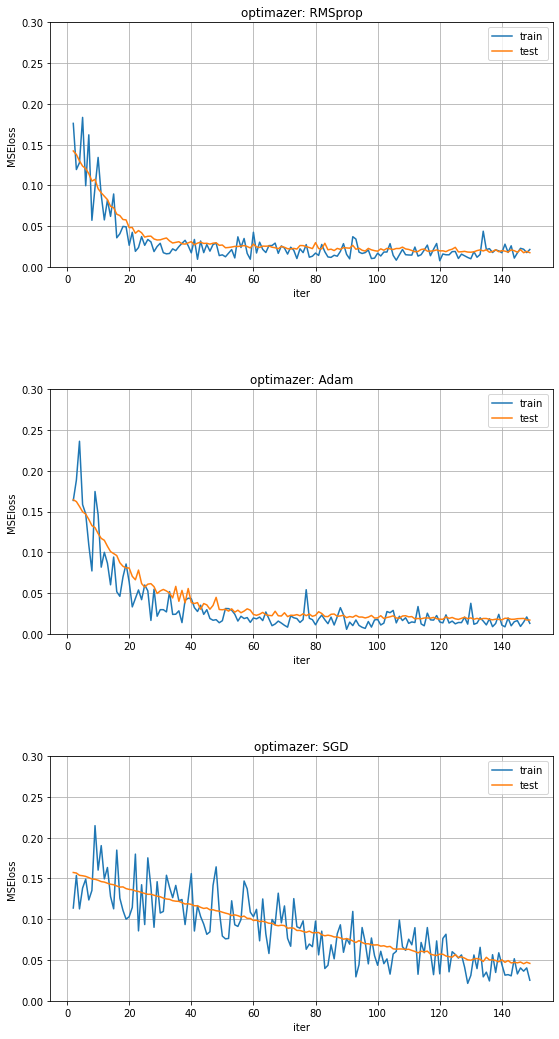

In [8]:
plt.figure(figsize=(9, 18))
i = 1
for key, optim_ in optim_list.items():
    plt.subplot(3, 1, i)
    plt.subplots_adjust(hspace=0.5)
    plt.title(f'optimazer: {key}')
    plt.plot(range(2, len(np.array(history[key])[:,2])), np.array(history[key])[2:,2], 
             label = 'train')
    plt.plot(range(2, len(np.array(history[key])[:,3])), np.array(history[key])[2:,3], 
             label = 'test')
    plt.legend()
    plt.xlabel('iter')
    plt.ylabel('MSEloss')
    plt.grid()
    plt.ylim(0,0.3)
    i +=1

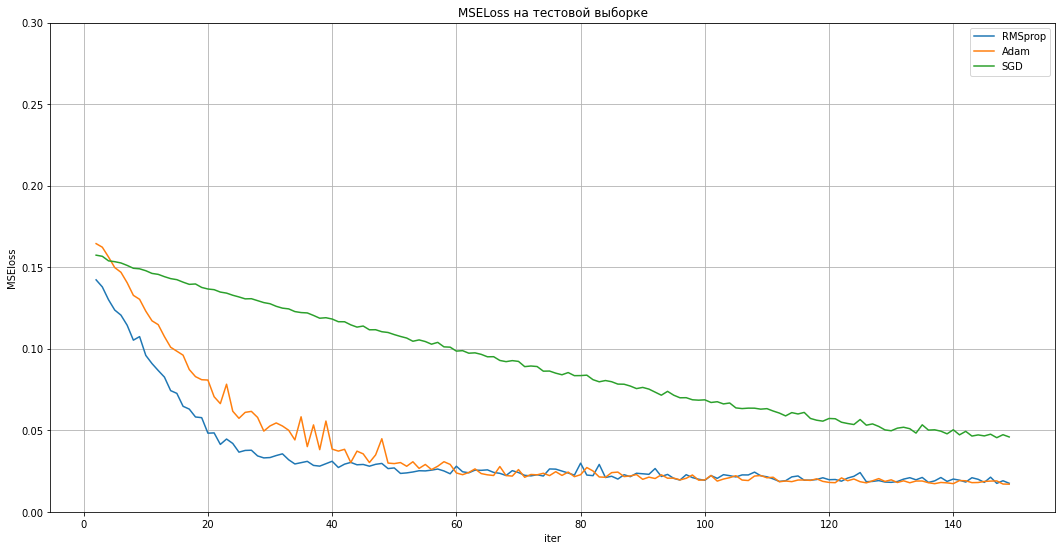

In [9]:
plt.figure(figsize=(18, 9))
for key, optim_ in optim_list.items():
    plt.title(f'MSELoss на тестовой выборке')
    plt.plot(range(2, len(np.array(history[key])[:,3])), np.array(history[key])[2:,3], label = key)
    plt.legend()
    plt.grid()
    plt.xlabel('iter')
    plt.ylabel('MSEloss')
    plt.ylim(0,0.3)
    i +=1

### Выводы

- Слой “Dropout” предназначен для борьбы с переобучением. В моём случае на графиках видно, что переобучения не возникает, поэтому использование данного слоя не требуется. 
- Слой “BatchNorm” - слой нормализации. Стоит на первом месте, выполняет первоначальную нормализацию данных. В силу того, что сеть не глубокая (2 “Linear” слоя) и переобучения не наступает использование второго слоя “BatchNorm” считаю не целесообразным.
<br><br>
- На графиках 1-3 видим, что переобучения не происходит, и сеть сходится:
    - Графики 'RMSprop', 'Adam' на обучающей выборки имеют меньшую неравномерность. Это связанно с тем, что шаг оптимизации происходит с учётом предыдущих состояний, что уменьшает скачки ошибки, связанные со стохастическим процессом.  SGD – не накапливает предыдущий опыт поэтому график сильно ломанный.
<br><br>
- Оценить сходимости можно на графике 4: 
    - Оптимизаторы 'RMSprop', 'Adam' в целом показали одинаковый результат. Разницу на начальном участке можно объяснить результатом случайной инициализации весов.  
    - SGD – значительно уступил двум другим как в скорости сходимости так и в минимальном loss. Следует заметить, что при SGD на 130-140 итерациях начинает прослеживаться переобучение, а значит SGD достичь меньшего loss при продолжении обучения уже не сможет.
